In [1]:
import yodo
import numpy as np
# import plotly.express as ex
import gc

In [2]:
parser = yodo.XMLParser("./datasets/RoadSigns/")

In [3]:
parser.parse()

In [4]:
parser

XMLParser @ /storage/detect/datasets/RoadSigns

In [5]:
hw = parser.as_dataframe()[['h','w']] * 384

In [6]:
hw.max()

h    373.932584
w    367.680000
dtype: float64

In [7]:
# ex.scatter(data_frame=hw,x='w',y='h')

In [8]:
IMG_SIZE = 384

In [9]:
8 * 32, 4 * 64, 2 * 128

(256, 256, 256)

In [10]:
anchor_config = yodo.utils.JSON({
    "img_size":IMG_SIZE,
    "config":[
        yodo.utils.JSON({
                'anchor_grid': {
                    'resize_factor': 32, 
                    'k': 9, 
                    'image_size': IMG_SIZE, 
                    'box_gen': {
                        'low': 0, 
                        'high': 48
                    }
                }, 
            'name': 'FPN0'
        }),
        yodo.utils.JSON({
                'anchor_grid': {
                    'resize_factor': 64, 
                    'k': 5, 
                    'image_size': IMG_SIZE, 
                    'box_gen': {
                        'low': 48, 
                        'high': 96
                    }
                }, 
            'name': 'FPN1'
        }),
        yodo.utils.JSON({
                'anchor_grid': {
                    'resize_factor': 128, 
                    'k': 3, 
                    'image_size': IMG_SIZE, 
                    'box_gen': {
                        'low': 96, 
                        'high': 224
                    }
                    
                }, 
            'name': 'FPN2'
        }),
    ]
})

In [11]:
anchors = yodo.Anchors(**anchor_config())

In [12]:
y_prob,y_boxes = anchors.encode_batch(parser)

In [13]:
y_prob.shape,y_boxes.shape

((877, 1503, 2), (877, 1503, 4))

In [14]:
images = yodo.utils.read_images(parser,anchor_config.img_size).astype(np.float32) / 255

In [15]:
gc.collect()

0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


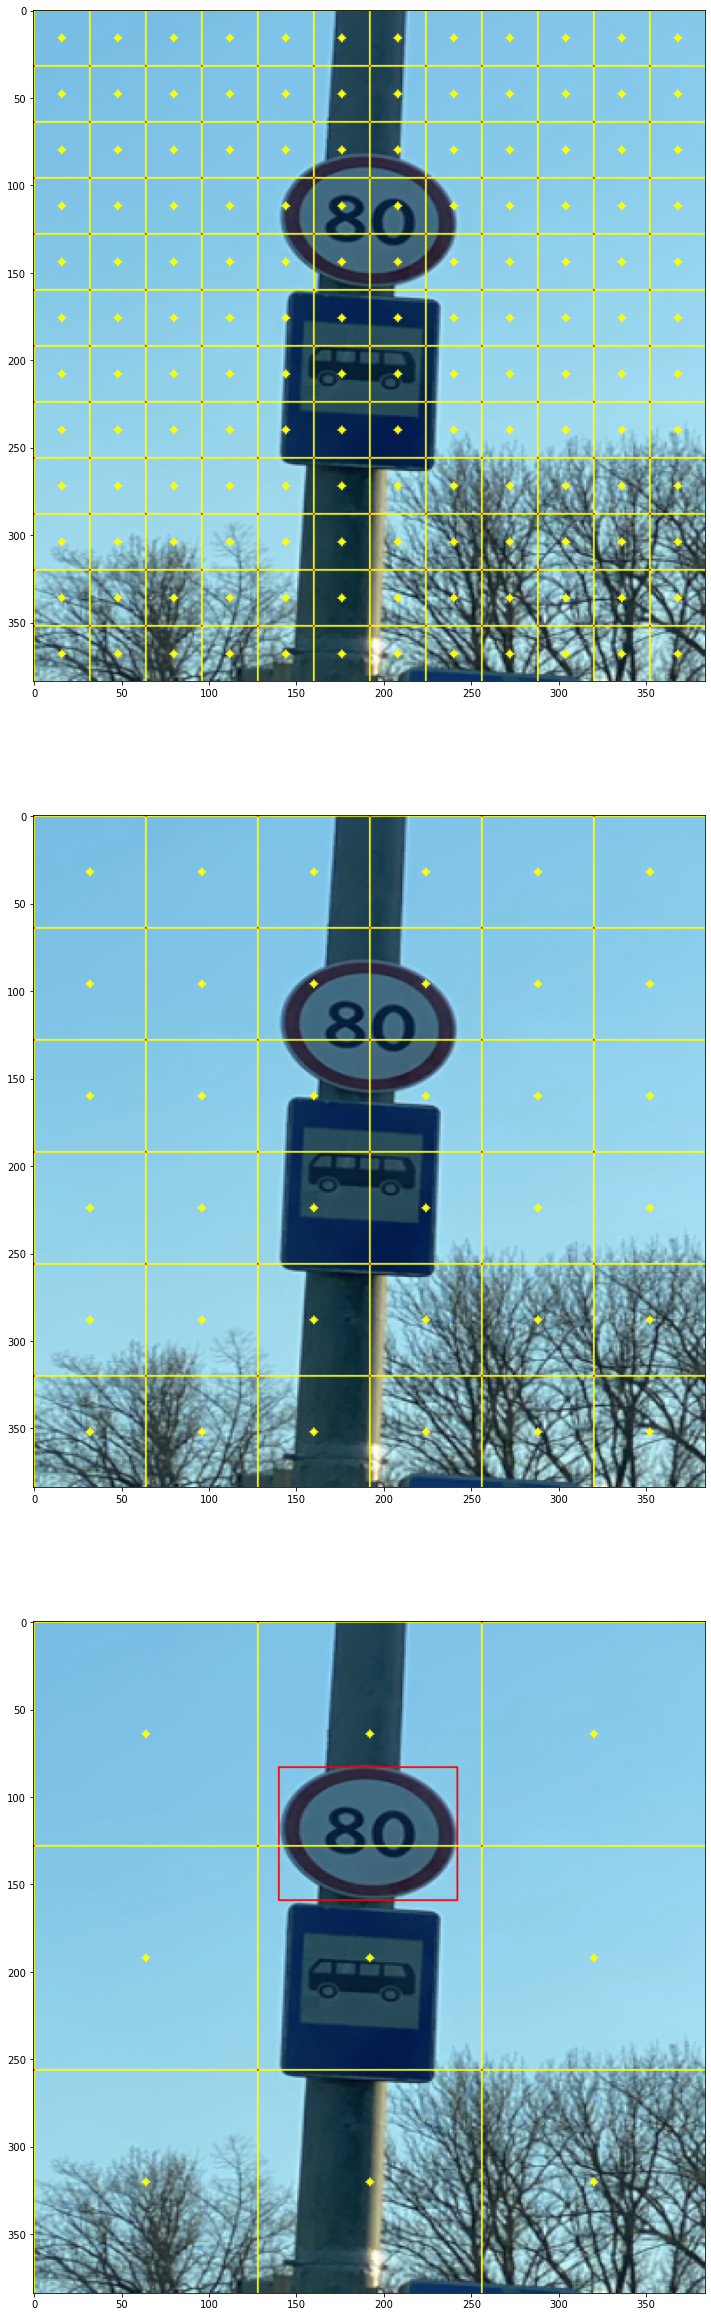

In [16]:
i = np.random.randint(0,len(images))
prob,boxes = anchors.encode(parser[i])
anchors.plot_grid(images[i],prob,boxes)

In [17]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,Callback

In [18]:
config = yodo.utils.JSON({
    "img_size":anchors.img_size,
    "backbone":[
        yodo.utils.JSON({
            "block":"block4X",
            "params":{
                "filters":32,
                "ksize":3,
                "name":"block_a",
                "pool":True
            }
        }),
        yodo.utils.JSON({
            "block":"block4X",
            "params":{
                "filters":32,
                "ksize":3,
                "name":"block_b",
                "pool":True
            }
        }),
        yodo.utils.JSON({
            "block":"block4X",
            "params":{
                "filters":32,
                "ksize":3,
                "name":"block_c",
                "pool":True
            }
        }),
        yodo.utils.JSON({
            "block":"block4X",
            "params":{
                "filters":32,
                "ksize":3,
                "name":"block_d",
                "pool":True
            }
        }),
    ],
    "proposals":[
        yodo.utils.JSON({
            "k":9,
            "params":{
                "filters":64,
                "ksize":3,
                "name":"opn_0",
                "pool":True
            }
        }),
        yodo.utils.JSON({
            "k":5,
            "params":{
                "filters":256,
                "ksize":3,
                "name":"opn_1",
                "pool":True
            }
        }),
        yodo.utils.JSON({
            "k":3,
            "params":{
                "filters":1024,
                "ksize":3,
                "name":"opn_2",
                "pool":True
            }
        })
    ]
})

In [19]:
yada = yodo.net.YODO(config=config)

In [20]:
optimizer = keras.optimizers.Adam()

In [21]:
train,test = yodo.net.get_split(len(images),71)

In [22]:
def schedule(epoch):
    if epoch > 5:
        return .0001
    else:
        return .0005
    
lrs = LearningRateScheduler(schedule=schedule,verbose=1)
chk = ModelCheckpoint(filepath="./checkpoints/net_SHIPS",save_weights_only=True,monitor='loss')

In [23]:
yada.build(optimizer=optimizer)

In [24]:
# yada.model.load_weights("./checkpoints/net_ROAD")

In [25]:
train_flow = yodo.net.flow(300,images,(y_prob,y_boxes),train)

In [26]:
yada.train_generator(train_flow,steps_per_epoch=len(train),epochs=300,callbacks=[lrs,chk])

Instructions for updating:
Please use Model.fit, which supports generators.

Epoch 00001: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 1/300
806/806 [==============================] - 73s 91ms/step - loss: 1.4733 - prob_loss: 0.6601 - box_loss: 0.8132 - lr: 5.0000e-04

Epoch 00002: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 2/300
806/806 [==============================] - 73s 91ms/step - loss: 1.1651 - prob_loss: 0.4747 - box_loss: 0.6904 - lr: 5.0000e-04

Epoch 00003: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 3/300
806/806 [==============================] - 73s 91ms/step - loss: 0.9754 - prob_loss: 0.3522 - box_loss: 0.6232 - lr: 5.0000e-04

Epoch 00004: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 4/300
806/806 [==============================] - 73s 91ms/step - loss: 0.8341 - prob_loss: 0.2633 - box_loss: 0.5709 - lr: 5.0000e-04

Epoch 00005: LearningRateScheduler reducing learning rate to 0.0005.
Epoch 5/300
80

806/806 [==============================] - 73s 91ms/step - loss: 0.2253 - prob_loss: 0.0169 - box_loss: 0.2084 - lr: 1.0000e-04

Epoch 00039: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 39/300
806/806 [==============================] - 73s 90ms/step - loss: 0.2229 - prob_loss: 0.0159 - box_loss: 0.2070 - lr: 1.0000e-04

Epoch 00040: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 40/300
806/806 [==============================] - 73s 90ms/step - loss: 0.2193 - prob_loss: 0.0150 - box_loss: 0.2043 - lr: 1.0000e-04

Epoch 00041: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 41/300
806/806 [==============================] - 73s 91ms/step - loss: 0.2167 - prob_loss: 0.0141 - box_loss: 0.2026 - lr: 1.0000e-04

Epoch 00042: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 42/300
806/806 [==============================] - 73s 90ms/step - loss: 0.2111 - prob_loss: 0.0133 - box_loss: 0.1978 - lr: 1.0000e-04

Epoch 00043: LearningRateSc

KeyboardInterrupt: 

In [ ]:
i = np.random.choice(train)
img = images[i].copy()

p,b = yada.model.predict(np.expand_dims(img,0))
boxes = anchors.decode(p,b)

for y,x,h,w in boxes:
    xmin = x - (w//2)
    ymin = y - (h//2)
    
    xmax = x + (w//2)
    ymax = y + (h//2)
    
    img = yodo.cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(255,0,0),1)
    img = yodo.cv2.circle(img,(x,y),2,(255,0,0),-1)
    
yodo.plt.figure(figsize=(12,12))
yodo.plt.imshow(img)